# 手写体图像识别实验

本案例会使用MindSpore深度学习框架利用全连接神经网络算法在MNIST数据集上实现一个简单的图片分类实验。

## 1、实验目的

- 学会如何搭建全连接神经网络。
- 掌握搭建网络过程中的关键点。
- 掌握分类任务的整体流程。

## 2、全连接神经网络算法原理介绍

浅层神经网络相比单层网络的差别在于隐藏层有多个神经节点，这就使得其可以处理“多输入多输出”的复杂问题。每一层的每一个节点都与上下层节点全部连接，这种神经网络称作全连接网络。

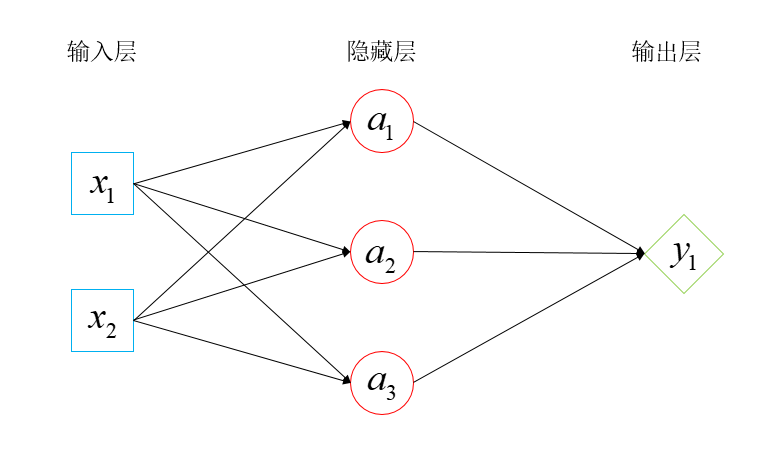

### 2.1 正向传播

$$z^{[1]} = \left\lgroup\begin{matrix}z_{1}^{[1]} \cr z_{2}^{[2]} \cr z_{3}^{[3]}\end{matrix}\right\rgroup = \left\lgroup\begin{matrix}w_{1}^{[1]T}\cdot x + b_{1}^{[1]} \cr w_{2}^{[2]T}\cdot x + b_{2}^{[2]} \cr w_{3}^{[3]T}\cdot x + b_{3}^{[3]}\end{matrix}\right\rgroup = \left\lgroup\begin{matrix}w_{1}^{[1]T}\cdot x \cr w_{2}^{[2]T}\cdot x \cr w_{3}^{[3]T}\cdot x  \end{matrix}\right\rgroup + b^{[1]} = W^{[1]}X + b^{[1]}$$



$$a^{[1]} = \left\lgroup\begin{matrix}a_{1}^{[1]} \cr a_{2}^{[2]} \cr a_{3}^{[3]}\end{matrix}\right\rgroup = \left\lgroup\begin{matrix}t\left(z_{1}^{[1]}\right) \cr t\left(z_{2}^{[2]}\right) \cr t\left(z_{3}^{[3]}\right)\end{matrix}\right\rgroup = t\left\lgroup\begin{matrix}\left(z_{1}^{[1]}\right) \cr \left(z_{2}^{[2]}\right) \cr \left(z_{3}^{[3]}\right) \end{matrix}\right\rgroup = t\left(z^{[1]}\right)$$

- 上角标中括号用于区分不同层
- 下角标数字表示神经元节点的映射关系
- 一个神经元节点包含上一层节点数$w$和$b$和下一层节点数$z$

### 2.2 反向传播

梯度下降法：

$$W = W - \alpha  \frac{\partial L}{\partial W}$$
$$b = b - \alpha  \frac{\partial L}{\partial b}$$

式中$W$和$b$为模型的权重参数，$L$为模型定义的损失函数，$\alpha$为超参数学习率；以上两式可以理解为：通过损失函数$L$对权重参数$W$和$b$进行求取导数，并利用导数乘以学习率对原来的$W$和$b$进行更新。

## 3、实验环境

- MindSpore 2.0（MindSpore版本会定期更新，本指导也会定期刷新，与版本配套）；
- 本案例支持win_x86和Linux系统，CPU/GPU/Ascend均可运行。
- 如果在本地运行此实验，请参考《MindSpore环境搭建实验手册》在本地安装MindSpore。

## 4、数据处理

### 4.1数据准备

MNIST是一个手写数字数据集，训练集包含60000张手写数字，测试集包含10000张手写数字，共10类。可在MNIST数据集的官网下载数据集，解压到当前代码目录下。MindSpore的dataset模块有专门用于读取和解析MNIST数据集的源数据集，可直接读取并生成训练集和测试集。

MNIST数据集下载地址："https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip" 。 

	将数据集下载并解压到本地路径下，这里将数据集解压分别存放到工作区的./MNIST_Data/train、./MNIST_Data/test路径下。

目录结构如下：

└─MNIST_Data

    ├─  test
    │      t10k-images.idx3-ubyte
    │      t10k-labels.idx1-ubyte
    │
    └─  train
            train-images.idx3-ubyte       
            train-labels.idx1-ubyte

In [1]:
from download import download

# 下载MNIST数据集
url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:08<00:00, 1.23MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


### 4.2数据加载

###### 导入模型库：

os模块主要用于对系统路径和文件进行处理。Numpy模块主要用于数据的基本运算操作。Matplotlib模块主要用于画图。MindSpore相关模块主要用于搭建网络、调用优化器、读取数据集和将数据集处理成网络的标准输入格式。

In [2]:
#导入相关依赖库
import  os
import numpy as np
from matplotlib import pyplot as plt

import mindspore as ms
#nn中有各种神经网络层如：Dense，ReLu
#context模块用于设置实验环境和实验设备
#load_checkpoint, load_param_into_net将模型参数存入parameter的字典中，并将参数加载到网络中
from mindspore import nn, context, load_checkpoint, load_param_into_net, Tensor
#dataset模块用于处理数据形成数据集
import mindspore.dataset as ds
#transforms模块用于转换数据类型
#vision模块用于转换图像，这是一个基于opencv的高级API
from mindspore.dataset import transforms, vision
#Model用于创建模型对象，完成网络搭建和编译，并用于训练和评估; 
#LossMonitor可以在训练过程中返回LOSS值作为监控指标；
#导入Accuracy作为评价指标。
from mindspore.train import Model, LossMonitor, Accuracy, CheckpointConfig, ModelCheckpoint

#设定运行模式为动态图模式，并且运行设备为昇腾芯片
context.set_context(mode=context.GRAPH_MODE, device_target='CPU') 

###### 加载并查看数据集

In [3]:
#MindSpore内置方法读取MNIST数据集
ds_train = ds.MnistDataset(os.path.join(r'./MNIST_Data', "train"))
ds_test = ds.MnistDataset(os.path.join(r'./MNIST_Data', "test")) 

print('训练数据集数量：',ds_train.get_dataset_size())
print('测试数据集数量：',ds_test.get_dataset_size())
#该数据集可以通过create_dict_iterator()转换为迭代器形式，然后通过__next__()一个个输出样本
image=ds_train.create_dict_iterator().__next__()
print(type(image))
print('图像长/宽/通道数：',image['image'].shape)
#一共10类，用0-9的数字表达类别。
print('一张图像的标签样式：',image['label'])  


训练数据集数量： 60000
测试数据集数量： 10000
<class 'dict'>
图像长/宽/通道数： (28, 28, 1)
一张图像的标签样式： 3


###### 数据预处理

创建数据集，为训练集设定Batch Size，这是因为我们通常会采用小批量梯度下降法（MBGD）来训练网络，所以Batch Size作为一个非常重要的超参数需要提前设定好。在本代码中，Batch Size为128，意味着每一次更新参数，我们都用128个样本的平均损失值来进行更新。

In [4]:
DATA_DIR_TRAIN = "./MNIST_Data/train" # 训练集信息
DATA_DIR_TEST = "./MNIST_Data/test" # 测试集信息

def create_dataset(training=True, batch_size=128, resize=(28, 28),rescale=1/255, shift=-0.5, buffer_size=64):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST, shuffle=True)
    
    #定义改变形状、归一化和更改图片维度的操作。
    trans_transform = [
                        #改为（28,28）的形状
                        vision.Resize(resize),
                        #rescale方法可以对数据集进行归一化和标准化操作，这里就是将像素值归一到0和1之间，shift参数可以让值域偏移至-0.5和0.5之间
                        vision.Rescale(rescale, shift),
                        #由高度、宽度、深度改为深度、高度、宽度
                        vision.HWC2CHW(),
                        ]
    label_transform = transforms.TypeCast(ms.int32)

    # 利用map操作对原数据集进行调整
    ds = ds.map(operations=trans_transform, input_columns=["image"])
    ds = ds.map(operations=label_transform, input_columns=["label"])

    ds = ds.batch(batch_size, drop_remainder=True)
    
    return ds


###### 查看数据

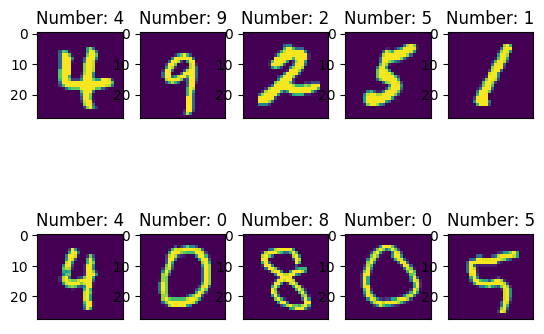

In [5]:
#显示前10张图片以及对应标签,检查图片是否是正确的数据集
dataset_show = create_dataset(training=False)
data = dataset_show.create_dict_iterator().__next__()
images = data['image'].asnumpy()
labels = data['label'].asnumpy()

for i in range(1,11):
    plt.subplot(2, 5, i)
    #利用squeeze方法去掉多余的一个维度
    plt.imshow(np.squeeze(images[i]))
    plt.title('Number: %s' % labels[i])
    plt.xticks([])
plt.show()


## 5、模型构建

手写数字图像数据集准备完成，接下来我们就需要构建训练模型，本实验采用的是全连接神经网络算法，所以我们首先需要建立初始化的神经网络。nn.cell能够用来组成网络模型;模型包括5个全连接层和RELU激活函数，一个全连接输出层并使用softmax进行多分类，共分成（0-9）10类。

In [6]:
#利用定义类的方式生成网络，Mindspore中定义网络需要继承nn.cell。在init方法中定义该网络需要的神经网络层
#在construct方法中梳理神经网络层与层之间的关系。
class ForwardNN(nn.Cell):      
    def __init__(self):
        super(ForwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Dense(784, 512, activation='relu')
        self.fc2 = nn.Dense(512, 256, activation='relu')
        self.fc3 = nn.Dense(256, 128, activation='relu')
        self.fc4 = nn.Dense(128, 64, activation='relu')
        self.fc5 = nn.Dense(64, 32, activation='relu')
        self.fc6 = nn.Dense(32, 10, activation='softmax')
    
    def construct(self, input_x):
        output = self.flatten(input_x)
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)   
        output = self.fc4(output)
        output = self.fc5(output)
        output = self.fc6(output)
        return output 


## 6、模型训练

指定模型所需的损失函数、评估指标、优化器等参数。将创建好的网络、损失函数、评估指标、优化器等参数装入模型中对模型进行训练。

In [7]:
lr = 0.001
num_epoch = 10
momentum = 0.9

net = ForwardNN()
#定义loss函数，改函数不需要求导，可以给离散的标签值，且loss值为均值
loss = nn.SoftmaxCrossEntropyWithLogits( sparse=True, reduction='mean')
#定义准确率为评价指标，用于评价模型
metrics={"Accuracy": Accuracy()}
#定义优化器为Adam优化器，并设定学习率
opt = nn.Adam(net.trainable_params(), lr)

#生成验证集，验证集不需要训练，所以不需要repeat
ds_eval = create_dataset(False, batch_size=32)
#模型编译过程，将定义好的网络、loss函数、评价指标、优化器编译
model = Model(net, loss, opt, metrics)

config_ck = CheckpointConfig(save_checkpoint_steps=1,keep_checkpoint_max=1)
ckpoint_cb = ModelCheckpoint(prefix= "checkpoint_classification", directory='./', config=config_ck)

#生成训练集
ds_train = create_dataset(True, batch_size=32)
print("============== Starting Training ==============")
#训练模型，用loss作为监控指标，并利用昇腾芯片的数据下沉特性进行训练
model.train(num_epoch, ds_train, callbacks=[LossMonitor(1875), ckpoint_cb], dataset_sink_mode=True)

============== Starting Training ==============
epoch: 1 step: 1875, loss is 1.5234758853912354
epoch: 2 step: 1875, loss is 1.712638258934021
epoch: 3 step: 1875, loss is 1.561658263206482
epoch: 4 step: 1875, loss is 1.9634921550750732
epoch: 5 step: 1875, loss is 1.688881516456604
epoch: 6 step: 1875, loss is 1.6168367862701416
epoch: 7 step: 1875, loss is 1.6472764015197754
epoch: 8 step: 1875, loss is 1.7423690557479858
epoch: 9 step: 1875, loss is 1.58613121509552
epoch: 10 step: 1875, loss is 1.6798397302627563


## 7、模型预测

利用模型对测试集的数据进行预测，并与标签对比，用准确率accuarcy进行评估。

In [8]:
#使用测试集评估模型，打印总体准确率
metrics_result=model.eval(ds_eval)
print(metrics_result)

{'Accuracy': 0.8227163461538461}


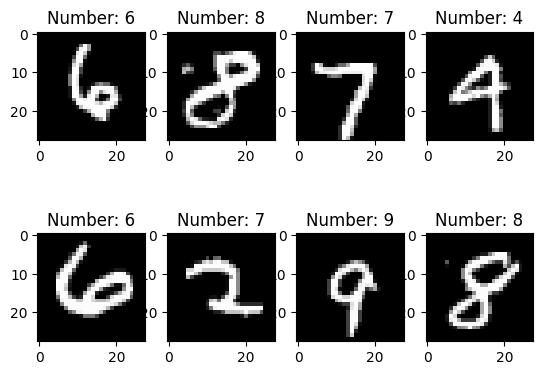

In [9]:
from mindspore import load_checkpoint, load_param_into_net, Tensor

# 将模型参数存入parameter的字典中，这里加载的是采用load_checkpoint接口
param_dict = load_checkpoint("./checkpoint_classification-10_1875.ckpt")
# 重新定义一个LeNet5神经网络
net = ForwardNN()
# 将参数加载到网络中
load_param_into_net(net, param_dict)
model = Model(network=net, loss_fn=loss, optimizer=opt, metrics={"Accuracy": nn.Accuracy()})
data_test = dataset_show.create_dict_iterator()
data = next(data_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

# 使用函数model.predict预测image对应分类
output = model.predict(Tensor(data['image']))
predicted = np.argmax(output.asnumpy(), axis=1)

plt.figure()
for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.imshow(images[i-1].squeeze(), cmap="gray")
    plt.title('Number: %s' % predicted[i-1])
plt.show()